In [1]:
%matplotlib widget
%load_ext autoreload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import yaml 
import tqdm
import collections.abc
import torch
from utils import PredictionResults
import os


deepracing_path = os.environ["DEEPRACING_PATH"]
print(deepracing_path)

deepracingmodelsdir = os.path.abspath(os.path.join(deepracing_path, "DCNN-Pytorch"))
deepracingdir = os.path.abspath(os.path.join(deepracing_path, "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path

homedir = os.environ["HOME"]

mtrdir=os.path.join(homedir, "deepracingws", "MTR")
print(mtrdir)
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(sys.path)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

/l/ttw2xk/deepracingws/src/deepracing
/l/ttw2xk/deepracingws/MTR
['/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch', '/l/ttw2xk/deepracingws/src/deepracing/deepracing_py', '/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/p/DeepRacing/deepracingws/src/deepracing/DCNN-Pytorch', '/p/DeepRacing/deepracingws/src/deepracing/deepracing_py', '/sw/ubuntu-22.04/python/3.10.13/lib/python310.zip', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10/lib-dynload', '', '/l/ttw2xk/python3venvs/deepracing310/lib/python3.10/site-packages', '/l/ttw2xk/deepracingws/MTR']


In [2]:

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils
import torch.utils.data as torchdata
keys : set = {
    "hist",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "thistory",
    "tfuture"
}
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files("/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard",
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)


bezier_experiment = "widespread_beans_6059"
bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BezierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_experiment = "chosen_preservative_7505"
composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_experiment = "agricultural_flue_8932"
mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_experiment = "formal_pedestal_9890"
mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results", mtr_experiment)
mtr_data_dir = "/p/DeepRacing/unpacked_datasets/local_fitting/v1/mtr_format/1second"
mtr_scenarios_dir = os.path.join(mtr_data_dir, "processed_scenarios_test")
mtr_sortfile = os.path.join(mtr_results_dir, "test_plots", "idx_sort.npz")
if not os.path.isfile(mtr_sortfile):
    with open(os.path.join(mtr_data_dir, "processed_scenarios_test_infos.pkl"), "rb") as f:
        mtr_infos = pkl.load(f)
    mtr_keys = mtr_infos[0].keys()
    entries = []
    for (idx, info) in tqdm.tqdm(enumerate(mtr_infos), total=len(mtr_infos)):
        scenario_id = info["scenario_id"]
        with open(os.path.join(mtr_scenarios_dir, scenario_id+".metadata.yaml"), "r") as f:
            scenario_metadata = yaml.safe_load(f)
        deepracing_dir = os.path.dirname(scenario_metadata["deepracing_file"])
        dset_index = scenario_metadata["index"]
        car_index = int(os.path.basename(deepracing_dir).split("_")[-1])
        dated_trackname : str = os.path.basename(os.path.dirname(deepracing_dir))
        trackname = dated_trackname.split("_")[0]
        entries.append((idx, scenario_id, trackname, car_index, dset_index))
    entries_sorted = sorted(entries, key=lambda entry : (entry[2], entry[3], entry[4]))
    scenario_ids_sorted = np.asarray([e[1] for e in entries_sorted], dtype=object)
    idx_sort = np.asarray([e[0] for e in entries_sorted], dtype=np.int64)
    with open(mtr_sortfile, "wb") as f:
        np.savez(f, idx_sort=idx_sort, scenario_ids=scenario_ids_sorted)

with open(mtr_sortfile, "rb") as f:
    npfile = np.load(f, allow_pickle=True)
    sort_idx_mtr = npfile["idx_sort"].copy()
    scenario_ids_sorted = npfile["scenario_ids"].copy()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "test_plots", "data.npz"), "MTR", sort_idx=sort_idx_mtr)
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))



Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15

In [3]:
%autoreload 2
from torch.utils.data import Subset
from utils import plot_error_histograms, plot_outliers

whis=None
pf=98.0
metric="ade"
results_base = "/p/DeepRacing/trajectory_prediction_results/sim_data"
nonoutliers, _ = composite_results.trim_percentiles(metric=metric, pf=pf)
outliers = ~nonoutliers
print(len(fulldset))
print(np.sum(nonoutliers))
print(np.sum(outliers))

composite_results_trimmed = composite_results.subsample(nonoutliers)
bezier_results_trimmed = bezier_results.subsample(nonoutliers)
mtr_results_trimmed = mtr_results.subsample(nonoutliers)
mixnet_results_trimmed = mixnet_results.subsample(nonoutliers)
fulldset_trimmed = Subset(fulldset, [i for i in range(nonoutliers.shape[0]) if bool(nonoutliers[i])])


# print(np.sum(mtr_nonoutliers*(~barte_nonoutliers)))
# print(np.sum(barte_nonoutliers*(~mtr_nonoutliers)))

126577
124045
2532


In [4]:


import shutil

rcparams_latex = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}

plots_dir = os.path.join(results_base, "plots")
histograms_dir = os.path.join(results_base, "histograms")
plots_dir_trimmed = os.path.join(results_base, "plots_trimmed")
histograms_dir_trimmed = os.path.join(results_base, "histograms_trimmed")

In [5]:
from utils import create_table
from texttable import Texttable

results_textable = create_table([composite_results, mtr_results, mixnet_results, bezier_results])
results_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_textable.draw())
results_trimmed_textable = create_table([composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed])
results_trimmed_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_trimmed_textable.draw())

+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.504 | 1.008 |  0.283  |    0.348     |
+--------------+-------+-------+---------+--------------+
|     MTR      | 0.524 | 1.065 |  0.175  |    0.450     |
+--------------+-------+-------+---------+--------------+
|    MixNet    | 1.892 | 3.476 |  0.463  |    1.706     |
+--------------+-------+-------+---------+--------------+
| BezierMixNet | 0.775 | 0.720 |  0.541  |    0.412     |
+--------------+-------+-------+---------+--------------+
+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.484 | 0.965 |  0.278  |    0.330     |
+-------------

In [6]:

maindir = "/p/DeepRacing/trajectory_prediction_results/sim_data/cross_error_analysis"
basedir = os.path.join(maindir, metric)
all_results_composite_ref = [composite_results, mtr_results, mixnet_results, bezier_results]
all_results_mtr_ref = [mtr_results, composite_results, mixnet_results, bezier_results]


In [7]:

%autoreload 2
from utils import cross_error_analysis
cross_error_analysis(all_results_composite_ref, fulldset, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis(all_results_mtr_ref, fulldset, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [8]:
%autoreload 2
from utils import cross_error_analysis
cross_error_analysis(all_results_composite_ref, fulldset, basedir, other_models=[mtr_results.modelname,], pf=pf, whis=whis, metric=metric)
cross_error_analysis(all_results_mtr_ref, fulldset, basedir, other_models=[composite_results.modelname,], pf=pf, whis=whis, metric=metric)

In [9]:

total_samples = composite_results[metric].shape[0]

barte_nonoutliers, barte_maxval = composite_results.trim_percentiles(metric=metric, pf=pf)
mtr_nonoutliers, mtr_maxval = mtr_results.trim_percentiles(metric=metric, pf=pf)

# mtr_nonoutliers, mtr_maxval = mtr_results.trim_iqr(metric=metric, whis=whis)
# barte_nonoutliers, barte_maxval = composite_results.trim_iqr(metric=metric, whis=whis)


In [10]:

barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = barte_inliers*mtr_inliers

barte_both_good = composite_results.subsample(both_good)
mtr_both_good = mtr_results.subsample(both_good)

dset_both_good : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_good.shape[0]) if both_good[i]])
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_merged", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_good, barte_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [11]:
barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=barte_maxval
both_good = barte_inliers*mtr_inliers

barte_both_good = composite_results.subsample(both_good)
mtr_both_good = mtr_results.subsample(both_good)

dset_both_good : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_good.shape[0]) if both_good[i]])
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_barte_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_good, barte_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [12]:
barte_inliers = composite_results[metric]<=mtr_maxval
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = barte_inliers*mtr_inliers

barte_both_good = composite_results.subsample(both_good)
mtr_both_good = mtr_results.subsample(both_good)

dset_both_good : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_good.shape[0]) if both_good[i]])
basedir = os.path.join(os.path.dirname(maindir), "both_models_good_mtr_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_good, barte_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [13]:
%autoreload 2
from utils import cross_error_analysis


barte_outliers = ~barte_nonoutliers
mtr_outliers = ~mtr_nonoutliers
both_bad = barte_outliers*mtr_outliers
barte_both_bad = composite_results.subsample(both_bad)
mtr_both_bad = mtr_results.subsample(both_bad)
dset_both_bad : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_bad.shape[0]) if bool(both_bad[i])])
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_merged", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_bad, barte_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_bad, mtr_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric, histograms=False)


In [14]:
%autoreload 2
from utils import cross_error_analysis


barte_outliers = composite_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>barte_maxval
both_bad = barte_outliers*mtr_outliers
barte_both_bad = composite_results.subsample(both_bad)
mtr_both_bad = mtr_results.subsample(both_bad)
dset_both_bad : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_bad.shape[0]) if bool(both_bad[i])])
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_barte_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_bad, barte_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_bad, mtr_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric, histograms=False)


In [15]:

barte_outliers = composite_results[metric]>mtr_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
both_bad = barte_outliers*mtr_outliers
barte_both_bad = composite_results.subsample(both_bad)

mtr_both_bad = mtr_results.subsample(both_bad)
dset_both_bad : torchdata.Subset = torchdata.Subset(fulldset, [i for i in range(both_bad.shape[0]) if bool(both_bad[i])])
basedir = os.path.join(os.path.dirname(maindir), "both_models_bad_mtr_maxval", metric)
os.makedirs(basedir, exist_ok=True)
cross_error_analysis([mtr_both_bad, barte_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric)
cross_error_analysis([barte_both_bad, mtr_both_bad], dset_both_bad, basedir, pf=None, whis=None, metric=metric, histograms=False)

35839
dict_keys(['fut', 'future_left_bd', 'thistory', 'fut_quats', 'tfuture', 'hist_quats', 'future_right_bd', 'hist_vel', 'left_bd', 'right_bd', 'fut_vel', 'hist', 'trackname'])


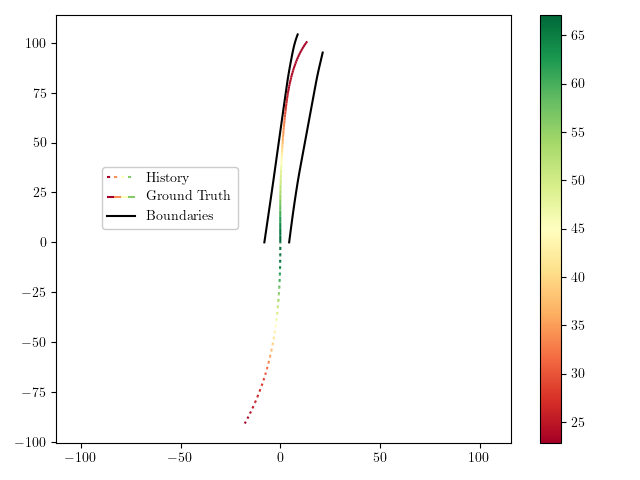

[58.84206189 58.98848613 59.14040229 59.26863243 59.3682688  59.46377473
 59.5793651  59.73485881 59.93586922 60.18281971 60.47657648 60.81073566
 61.16825972 61.53060612 61.88141008 62.22542869 62.57819558 62.95634326
 63.36521663 63.79383469 64.2284924  64.65523806 65.06969327 65.47390806
 65.87176923 66.26001528 66.61401321 66.90365807 67.08397189 66.99351427
 66.41070486]


In [132]:


# idx_good = plot_outliers([composite_results, mtr_results, mixnet_results, bezier_results], plots_dir, fulldset, N=25, metric_key="ade", worst=False)




# sample = fulldset[idx_good[26]]
from scipy.spatial.transform import Rotation
from matplotlib.collections import LineCollection, Collection
from matplotlib.colors import BoundaryNorm, ListedColormap, Colormap
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.patches import ArrowStyle
import matplotlib.cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.axes, matplotlib.figure
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                     transform=trans, linestyle=artist.get_linestyle())
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]
def add_colored_line(points : np.ndarray, cvals : np.ndarray, ax : matplotlib.axes.Axes, cmap : str | Colormap, 
    linestyle="solid", alpha=1.0) -> tuple[LineCollection, Collection]:
    points_exp = points.reshape(-1, 1, points.shape[-1])
    segments = np.concatenate([points_exp[:-1], points_exp[1:]], axis=1)
    norm = plt.Normalize(cvals.min(), cvals.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm,linestyle=linestyle, alpha=alpha)
    
    lc.set_array(cvals)
    line = ax.add_collection(lc)
    return lc, line
# mtr_outliers = ~mtr_nonoutliers
# mtr_outliers_idx = np.where(mtr_outliers)[0]
mtr_argsort = np.flipud(np.argsort(mtr_results["ade"]))
# idx_rand = np.random.choice(mtr_outliers_idx)
idx_rand = mtr_argsort[7]
sample = fulldset[idx_rand]
print(idx_rand)
print(sample.keys())

Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_start = 30
history = (Rmat @ sample["hist"][history_start:,[0,1]].T).T
history_vels = (Rmat @ sample["hist_vel"][history_start:,[0,1]].T).T
history_speeds = np.linalg.norm(history_vels, ord=2.0, axis=1)

ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
ground_truth_vels = (Rmat @ sample["fut_vel"][:,[0,1]].T).T
ground_truth_speeds = np.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

all_points = np.concatenate([history, ground_truth], axis=0)
all_speeds = np.concatenate([history_speeds, ground_truth_speeds], axis=0)




thistory = sample["thistory"]
tfuture = sample["tfuture"]
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
asdf : tuple[matplotlib.figure.Figure, matplotlib.axes.Axes] = plt.subplots(1,1)
fig : matplotlib.figure.Figure = asdf[0]
ax : matplotlib.axes.Axes = asdf[1]
ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black")
boundaries = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle="solid", color="black")
norm = plt.Normalize(all_speeds.min(), all_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
lc_hist, line_hist = add_colored_line(history, history_speeds[:-1], ax, cmap, linestyle="dotted")
lc_ground_truth, line_ground_truth  = add_colored_line(ground_truth, ground_truth_speeds[:-1], ax, cmap)
line_ground_truth.set_label("asdf")
lc_ground_truth.set_label("asdf")
# lc_fake, line_fake  = add_colored_line(all_points, all_speeds[:-1], ax, cmap, alpha=0.25)

# ax.plot(history[:,0], history[:,1], linestyle="--", color=history_speeds, cmap="viridis", norm=norm, alpha=0.5, label="History")
# ax.plot(ground_truth[:,0], ground_truth[:,1], linestyle="dotted", color="black", label="Ground Truth")
ax.axis("equal")
ax.legend([
               lc_hist, 
               lc_ground_truth,
               boundaries[0],
           ],
           [
               "History", 
               "Ground Truth", 
               "Boundaries",
           ], loc=(0.1, 0.5),
          handler_map={
              lc_hist: HandlerColorLineCollection(numpoints=4),
              lc_ground_truth: HandlerColorLineCollection(numpoints=4),

            },
            framealpha=1)
fig.tight_layout()
os.makedirs(plots_dir, exist_ok=True)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(plots_dir, "label_nobar.svg"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "label_nobar.pdf"), pad_inches=0.02)
fig.colorbar(scalar_mappable, ax=ax)
fig.savefig(os.path.join(plots_dir, "label.svg"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "label.pdf"), pad_inches=0.02)
# fig2  = plt.figure()
# plt.plot(thistory, history_speeds)
# plt.plot(tfuture, ground_truth_speeds)
plt.show()
print(history_speeds)
# plt.close(fig=fig)


(80, 2)


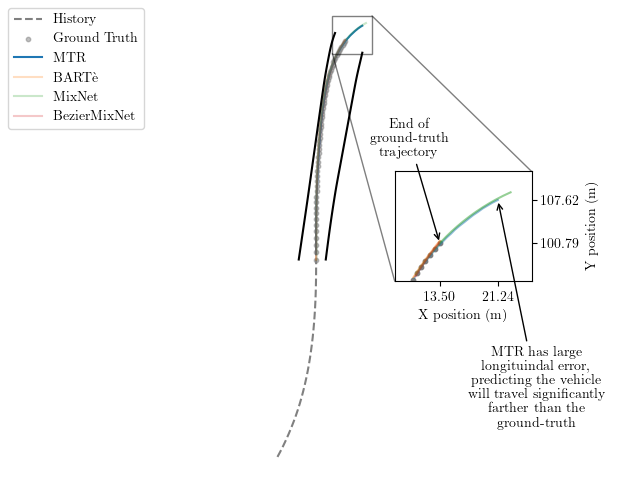

In [17]:
import os
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
plt.rcParams["text.usetex"]=True
results_list = all_results_mtr_ref
ref_results = results_list[0]
ref_alpha=1.0
nonref_alpha=0.25

artist_dict : dict[str,matplotlib.lines.Line2D | matplotlib.collections.PathCollection] = dict()
fig, _axmain_ = plt.subplots()
axmain : matplotlib.axes.Axes = _axmain_
history_label = "History"
artist_dict[history_label] = axmain.plot(history[:,0], history[:,1], label=history_label, linestyle="--", c="grey")[0]
ground_truth_label = "Ground Truth"
artist_dict[ground_truth_label] = axmain.scatter(ground_truth[:,0], ground_truth[:,1], label=ground_truth_label, c="grey", alpha=0.5, s=10.0)
print(ref_results["predictions"][idx_rand].shape)
mtr_predictions = (Rmat @ ref_results["predictions"][idx_rand][:,[0,1]].T).T
p0 = ground_truth[-1] - 6.0
pf = mtr_predictions[-1] + 4.5
delta = pf - p0
artist_dict[ref_results.modelname] = axmain.plot(mtr_predictions[:,0], mtr_predictions[:,1], label=ref_results.modelname, alpha=ref_alpha)[0]
predictions_dict : dict[str,np.ndarray] = dict()
predictions_dict[mtr_results.modelname] = mtr_predictions
predictions_dict["Ground Truth"] = ground_truth
predictions_inset_dict : dict[str,np.ndarray] = dict()
p0deltas = mtr_predictions - p0[None]
pfdeltas = -mtr_predictions + pf[None]
predictions_inset_dict[mtr_results.modelname] = mtr_predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
p0deltas = ground_truth - p0[None]
pfdeltas = -ground_truth + pf[None]
ground_truth_inset = ground_truth[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
for (idx, results) in enumerate(results_list):
    if results==ref_results:
        continue
    predictions = (Rmat @ results["predictions"][idx_rand][:,[0,1]].T).T
    if results.modelname==composite_results.modelname:
        label="BART\\`e"
    else:
        label=results.modelname
    artist_dict[results.modelname] = axmain.plot(predictions[:,0], predictions[:,1], label=label, alpha=nonref_alpha)[0]
    predictions_dict[results.modelname] = predictions.copy()
    p0deltas = predictions - p0[None]
    pfdeltas = -predictions + pf[None]
    predictions_inset_dict[results.modelname] = predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
barte_predictions = predictions_dict[composite_results.modelname]
mixnet_predictions = predictions_dict[mixnet_results.modelname]

left_bound_input = sample["left_bd"]
artist_dict["left_bound"] = axmain.plot(future_left_bd[:,0], future_left_bd[:,1], color="black")[0]
right_bound_input = sample["right_bd"]
artist_dict["right_bound"] = axmain.plot(future_right_bd[:,0], future_right_bd[:,1], color=artist_dict["left_bound"].get_color())[0]
axmain.axis("equal")
fig.canvas.draw()
margins = axmain.margins()
xlim = np.asarray(axmain.get_xlim())
ylim = np.asarray(axmain.get_ylim())
lim_deltas = np.asarray([xlim[1] - xlim[0], ylim[1] - ylim[0]])
inset_origin = np.asarray([50, -10])
inset_origin_norm = (inset_origin - np.asarray([xlim[0], ylim[0]]))/lim_deltas
axinset : matplotlib.axes.Axes = axmain.inset_axes(
    [
        inset_origin_norm[0], 
        inset_origin_norm[1], 
        0.23, 
        0.23],
    xlim=(p0[0], pf[0]), ylim=(p0[1], pf[1]), xticklabels=[], yticklabels=[])
for (k, v) in predictions_inset_dict.items():
    mplobject = artist_dict[k]
    if type(mplobject) is matplotlib.collections.PathCollection:
        color = mplobject.get_facecolor()
    elif type(mplobject) is matplotlib.lines.Line2D:
        color = mplobject.get_color()
    else:
        raise ValueError("?")
    axinset.plot(v[:,0], v[:,1], label=k, color=color, alpha=0.5)
axinset.scatter(ground_truth_inset[:,0], ground_truth_inset[:,1], label="Ground Truth", c="grey", alpha=1.0, s=10.0)
theta = (np.pi/180.0)*37.5
fontsize=10
label_lines=["End of",
            "ground-truth",
            "trajectory"]
label=""
for line in label_lines:
    label+=line
    label+="\n"
label = label.strip()
gtend_annotation = axinset.annotate(label, 
                        ground_truth_inset[-1], xycoords="data",
                       xytext=90.0*np.asarray([-0.2, 1.0]), textcoords="axes points", fontsize=fontsize,
                       arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
                       annotation_clip=False, multialignment="center")
label_lines=["MTR has large",
            "longituindal error,",
            "predicting the vehicle",
            "will travel significantly",
            "farther than the",
            "ground-truth"]
label=""
for line in label_lines:
    label+=line
    label+="\n"
label = label.strip()
gtend_annotation = axinset.annotate(label, 
                        mtr_predictions[-1], xycoords="data",
                       xytext=105.0*np.asarray([0.5, -1.0]), textcoords="axes points", fontsize=fontsize,
                       arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
                       annotation_clip=False, multialignment="center")
axmain.indicate_inset_zoom(axinset, edgecolor="black")
axmain.get_xaxis().set_ticks([])
axmain.get_yaxis().set_ticks([])
for pos in ['right', 'top', 'bottom', 'left']: 
    axmain.spines[pos].set_visible(False) 
axmain.legend()#loc="upper left", bbox_to_anchor=(0.25, 1.0))
# xticks = np.linspace(p0[0]+0.1*delta[0], pf[0]-0.1*delta[0], num=3)
# yticks = np.linspace(p0[1]+0.1*delta[1], pf[1]-0.1*delta[1], num=3)
historymin = np.min(history[:,0])
historymax = np.max(history[:,0])
axmain.set_xlim(historymin, historymax + 2.0)
xticks = np.asarray([ground_truth[-1,0], mtr_predictions[-1,0]])
yticks = np.asarray([ground_truth[-1,1], mtr_predictions[-1,1]])
# xticks = yticks = []
axinset.set_xticks(xticks, ["%3.2f" % float(v) for v in xticks])
axinset.set_yticks(yticks, ["%3.2f" % float(v) for v in yticks])
axinset.yaxis.tick_right()
axinset.yaxis.set_label_position("right")
axinset.set_xlabel("X position (m)")
axinset.set_ylabel("Y position (m)")
# axinset.legend()
# fig.canvas.draw()
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(plots_dir, "example_predictions.pgf"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "example_predictions.pdf"), pad_inches=0.02)
plt.show()

dict_keys(['history', 'history_vel', 'curves', 'ground_truth', 'ground_truth_vel', 'predictions', 'lateral_error', 'longitudinal_error', 'ade', 'fde', 'vel_predictions', 'left_bd', 'right_bd'])


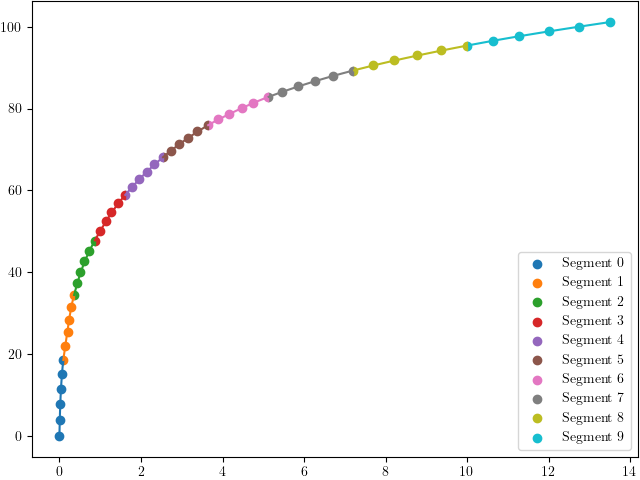

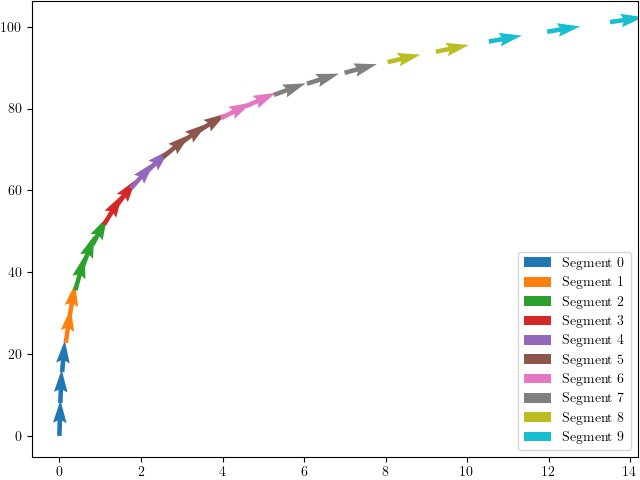

In [122]:
import deepracing_models.math_utils
from matplotlib.markers import MarkerStyle

print(composite_results.keys())
device = torch.device("cpu")
dtype = torch.float64
predicted_curve = torch.as_tensor(composite_results["curves"][idx_rand], device=device, dtype=dtype)
predicted_curve = (torch.as_tensor(Rmat, device=device, dtype=dtype)[None, None] @ predicted_curve[...,None]).squeeze(-1)
tfuture_torch = torch.as_tensor(tfuture - tfuture[0], device=device, dtype=dtype)
tswitch = torch.linspace(0.0, tfuture_torch[-1], steps=predicted_curve.shape[0] + 1, device=device, dtype=dtype)
tstart = tswitch[:-1]
dt = tswitch[1:] - tstart
bezier_order = predicted_curve.shape[-2] - 1
predicted_vel_curve = bezier_order*(predicted_curve[:,1:] - predicted_curve[:,:-1])/dt[...,None,None]


tsamp_torch = torch.linspace(0.0, tfuture_torch[-1].item(), steps=25, dtype=dtype, device=device)

tsamp_torch_dense = torch.linspace(0.0, tfuture_torch[-1].item(), steps=600, dtype=dtype, device=device)
predicted_positions_dense, idx_buckets_dense = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch_dense)

predicted_vels, _ = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_vel_curve, tsamp_torch)

fig_positions, _ax_positions_ = plt.subplots()
ax_positions : matplotlib.axes.Axes = _ax_positions_
segments_colors = []
bool_idx = idx_buckets_dense==0
current_control_points = predicted_curve[0].cpu()
current_positions = predicted_positions_dense[bool_idx]
current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
ax_positions.scatter(current_control_points[:-1,0], current_control_points[:-1,1], c=current_color, label="Segment 0")
segments_colors.append(current_color)
for curve_idx in range(1, predicted_curve.shape[0]):
    bool_idx = idx_buckets_dense==curve_idx
    current_positions = predicted_positions_dense[bool_idx]
    current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
    segments_colors.append(current_color)
    label="Segment %d" % (curve_idx,)

    current_control_points = predicted_curve[curve_idx].cpu()
    ax_positions.scatter(current_control_points[1:-1,0], current_control_points[1:-1,1], c=current_color, label=label)
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=current_color, edgecolor=None, marker=MarkerStyle("o", fillstyle="right"))
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=segments_colors[-2], edgecolor=None, marker=MarkerStyle("o", fillstyle="left"))
ax_positions.scatter(predicted_curve[-1,-1,0], predicted_curve[-1,-1,1], c=segments_colors[-1])
ax_positions.legend()
# ax_positions.axis("equal")
# ax_positions.axis("equal")
predicted_positions, idx_buckets = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch)
fig_arrows, _ax_arrows_ = plt.subplots()
ax_arrows : matplotlib.axes.Axes = _ax_arrows_
skip=4
for curve_idx in range(predicted_curve.shape[0]):
    bool_idx = idx_buckets==curve_idx
    current_positions = predicted_positions[bool_idx]
    current_vels = predicted_vels[bool_idx]
    current_color = segments_colors[curve_idx]
    label="Segment %d" % (curve_idx,)
    ax_arrows.quiver(current_positions[:,0], current_positions[:,1], current_vels[:,0], current_vels[:,-1], angles="xy", color=current_color, label=label)
ax_arrows.legend()
# ax_arrows.axis("equal")
fig_positions.tight_layout(pad=0.1)
fig_positions.savefig(os.path.join(plots_dir, "positions.svg"), pad_inches=0.02)
fig_positions.savefig(os.path.join(plots_dir, "positions.png"), backend="agg", pad_inches=0.02)
fig_arrows.tight_layout(pad=0.1)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.svg"), pad_inches=0.02)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.png"), backend="agg", pad_inches=0.02)